# Atividade prática 4
### Retoque de imagens digitais

Sabe quando a gente tira do baú um álbum de família, mas quando viramos uma página, eis que alguns pedaços de uma fotografia ficam grudados nele?
Há um tempo atrás, muita gente experimentou esta situação.
Nos dias de hoje, isto pode ser transposto para o contexto das fotos digitais, por exemplo, quando desejamos recuperar uma foto antiga deteriorada que foi digitalizada ou remover algum objeto indesejado presente na cena.
Este tipo de problema é o conhecido como **retoque digital**.
Nesta atividade, você aprenderá como implementar um algoritmo simples de retoque digital que se resume em resolver um sistema de equações algébricas lineares.

Por conveniência, a tarefa está dividida nas etapas:

1. [Construção de imagens usando `arrays`](#celula-exemplo-imagem)
1. [Compreendendo o algoritmo de retoque](#celula-exemplo-sistema)
1. [Escolha de uma imagem teste](#celula-imagem-original)
1. [Identificação dos pixels indesejados](#celula-pixels-indesejados)
1. [Montagem dos sistemas de equações](#celula-montagem)
1. [Implementação de um método de solução de sistemas lineares](#celula-resolve)
1. [Visualização da imagem retocada](#celula-imagem-retocada)

## Imagens digitais

Uma *imagem digital* pode ser vista como uma matriz $\mathbf{P} = \left[ p_{ij} \right]$, $n_x\times n_y$, onde cada elemento $p_{ij}$ é denominado *pixel*.
Existem diversas formas de se representar a cor de um pixel.
No sistema conhecido como RGB (do inglês, *Red*, *Green*, *Blue*), a cor de um pixel é representada usando três canais: <font color="red">vermelho</font>, <font color="green">verde</font> e <font color="blue">azul</font>.
Supondo cada canal representado com 8 bits, teremos $2^8 = 256$ valores distintos por canal.
A combinação dos três canais possibilita a criação de 256 x 256 x 256 cores, o que é algo em torno de 16 milhões de cores.

Matematicamente, a cor de um pixel $p_{i,j}$ é representada por uma vetor $\left( r, g, b\right)$, onde $0 \le r,g,b \le 255$.
Quanto maior o valor de um canal, maior será a intensidade dele na cor final obtida.
Algumas exemplos de combinações de canais são:

* $(255,0,0)$: <span style='color: rgb(255,0,0)'>vermelho</span>
* $(0,255,0)$: <span style='color: rgb(0,255,0)'>verde</span>
* $(0,0,255)$: <span style='color: rgb(0,0,255)'>azul</span>
* $(255,255,0)$: <span style='color: rgb(255,255,0)'>amarelo</span>
* $(0,255,255)$: <span style='color: rgb(0,255,255)'>ciano</span>
* $(255,0,255)$ <span style='color: rgb(255,0,255)'>magenta</span>
* $(0,0,0)$: <span style='color: rgb(0,0,0)'>preto</span>
* $(125,127,127)$: <span style='color: rgb(127,127,127)'>cinza médio</span>
* $(255,255,255)$: <span style='color: rgb(255,255,255)'>branco</span> (não dá para ver, não é? :))

Em Python, fica fácil manipular imagens usando a biblioteca `imageio`:

In [6]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

Ao carregar uma imagem a partir de um endereço

In [ ]:
imagem = imageio.imread('http://sipi.usc.edu/database/preview/misc/4.2.03.png')

## Escolha da imagem teste

Caso desejar, você pode também abrir um arquivo em seu computador passando o caminho absoluto ou relativo até a imagem desejada para a função `imageio.imread`.

Depois de carregar a imagem, podemos exibir suas dimensões (o que chamamos de *resolução espacial*) e a quantidade de canais presentes:

In [ ]:
nx,ny,nc = imagem.shape
nx,ny,nc

(200, 200, 4)

Os números acima significam que a imagem possui 525 pixels de altura, 700 pixels de largura e 4 canais de cor.
O quarto canal é conhecido como *canal alfa*, utilizado para representar transparência (0 é transparência total, e 255 é totalmente opaco).
No entanto, considerando o que precisamos fazer nesta tarefa, este canal pode ser ignorado.

Como a imagem agora é um `numpy.array`, podemos acessar um pixel $p_{i,j}$ usando indexação. Por exemplo,

In [ ]:
imagem[31,23]

Array([138, 132,  74, 255], dtype=uint8)

tem como resultado os valores RGB(A) do pixel $p_{31,23}$, além do tipo utilizado para armazená-lo, que neste caso é um `uint8` (um inteiro não negativo ocupando 8 bits).

Agora, podemos usar a `matplotlib` para visualizar a `imagem` carregada:

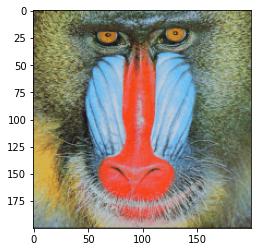

In [ ]:
plt.imshow(imagem) # cria um gráfico cujo fundo é a imagem
plt.show() # exibe o gráfico criado

<a name="celula-exemplo-imagem"></a>
(a) Sabendo que podemos representar uma imagem usando `arrays` da `numpy`, construa e exiba uma imagem RGB $4 \times 4$ cujos valores dos pixels são dados pela tabela:

\begin{array}{|c|c|c|c|}
\hline
(177,33,42) & (2,154,23) & (255,255,1) & (0,32,127)\\
\hline
(4,4,4) & (255,0,0) & (3,10,200) & (3,10,200)\\
\hline
(0,32,127) & (255,0,0) & (177,33,42) & (2,154,23)\\
\hline
(2,154,23) & (177,33,42) & (32,7,150) & (0,32,127)\\
\hline
\end{array}

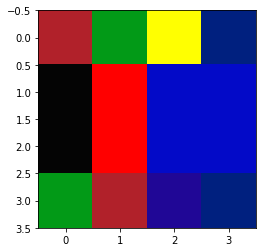

(4, 4, 3)

In [ ]:
# seu código vem aqui
imagemT1 = np.array([[[177,33,42],[2,154, 23],[255,255,1],[0,32,127]], 
                    [[4,4,4],[255,0,0],[3,10,200],[3,10,200]], 
                    [[4,4,4],[255,0,0],[3,10,200],[3,10,200]], 
                    [[2,154,23],[177,33,42],[32,7,150],[0,32,127]]])
plt.imshow(imagemT1)
plt.show()
nx,ny,nc = imagemT1.shape
nx,ny,nc

## Algoritmo de retoque digital

O objetivo de um algoritmo de retoque é preencher porções de pixels indesejados de uma foto baseando-se nas cores de pixels vizinhos que serão preservados.
Um bom algoritmo deve produzir uma imagem nova com emendas imperceptíveis entre as regiões que foram mantidas intactas e aquelas recém preenchidas por ele.
A imagem abaixo contém um exemplo de aplicação de um algoritmo de retoque.
Do lado esquerdo, a imagem original, com riscos em vermelho, e o resultado final do lado direito, com os riscos removidos.

<img style="height:256px" src="https://www.pyimagesearch.com/wp-content/uploads/2020/05/opencv_inpainting_header.jpg"/>

Um algoritmo simples de retoque funciona do seguinte modo.
Primeiramente, você deve indicar quais pixels na imagem você deseja retocar.
Isto pode ser feito pintando a região indesejada utilizando uma única cor de código conhecido, por exemplo, vermelho, como na imagem acima.
Por conveniência, assumiremos que **nenhum pixel indesejado pertencerá à borda da imagem**.

Suponha que $P = \left[p_{i,j}\right]$ é a imagem já com as regiões indesejadas indicadas em vermelho.
Se a cor de $p_{i,j}$ for diferente de vermelho, então este pixel será preservado e nada será feito com relação a ele.
Caso contrário, sua cor será recalculada como a seguir.

Considere os pixels vizinhos de $p_{i,j}$ localizados imediatamente acima $p_{i-1,j}$, abaixo $p_{i+1,j}$, à esquerda $p_{i,j-1}$ e à direita $p_{i,j+1}$.
A nova cor de $p_{i,j}$ será a média aritmética das cores de seus vizinhos, isto é,

$$
(r_{i,j},g_{i,j},b_{i,j}) = \frac{1}{4} \left[ (r_{i-1,j},g_{i-1,j},b_{i,j}) + (r_{i,j-1},g_{i,j-1},b_{i,j-1}) + (r_{i,j+1},g_{i,j+1},b_{i,j+1}) + (r_{i+1,j},g_{i+1,j},b_{i+1,j}) \right]
$$

Considerando separadamente o canal vermelho, podemos escrever esta expressão da seguinte forma:

$$
-r_{i-1,j} - r_{i,j-1} + 4 r_{i,j} - r_{i,j+1} - r_{i+1,j} = 0
$$

Se um dos pixels vizinhos de $p_{i,j}$ precisar ser preservado, sua cor deve ser tratada como constante. Neste caso, esta parcela deverá ser transferida para a direita desta equação.

Supondo um total de $N$ pixels indesejados, a aplicação da equação acima em cada um deles resultará em três sistemas lineares com $N$ equações e $N$ incógnitas, um para cada canal RGB, todos com a mesma matriz de coeficientes:

\begin{align*}
\mathbf{A}\mathbf{x}_r &= \mathbf{b}_r\\
\mathbf{A}\mathbf{x}_g &= \mathbf{b}_g\\
\mathbf{A}\mathbf{x}_b &= \mathbf{b}_b
\end{align*}

Após resolver estes sistemas, basta atualizar as cores dos pixels indesejados com aquelas que foram calculadas e voilà! Sua imagem terá sido retocada!

<a name="celula-exemplo-sistema"></a>
(b) Considere a imagem construída no item (a).
Supondo que os pixels indesejados ali estão indicados em vermelho, preencha os três sistemas abaixo que serão gerados pelo algoritmo de retoque descrito há pouco.

* Canal vermelho:
$$
\begin{bmatrix}
a_{00} & a_{01}\\
a_{10} & a_{11}
\end{bmatrix}
\begin{bmatrix}
x_{0}\\
x_{1}
\end{bmatrix}_{r}
=
\begin{bmatrix}
b_{0}\\
b_{1}
\end{bmatrix}_{r}
$$

* Canal verde:
$$
\begin{bmatrix}
a_{00} & a_{01}\\
a_{10} & a_{11}
\end{bmatrix}
\begin{bmatrix}
x_{0}\\
x_{1}
\end{bmatrix}_{g}
=
\begin{bmatrix}
b_{0}\\
b_{1}
\end{bmatrix}_{g}
$$

* Canal azul:
$$
\begin{bmatrix}
a_{00} & a_{01}\\
a_{10} & a_{11}
\end{bmatrix}
\begin{bmatrix}
x_{0}\\
x_{1}
\end{bmatrix}_{b}
=
\begin{bmatrix}
b_{0}\\
b_{1}
\end{bmatrix}_{b}
$$

## Escolha da imagem teste

<a name="celula-imagem-original"></a>
(c) Nesta etapa, vocês devem escolher a imagem que será usada para testar o algoritmo de retoque.
Vocês devem apenas exibir a imagem original aqui, descrevendo sua origem.
Pode ser uma foto tirada por vocês ou uma imagem escolhida na internet.
Há diversos repositórios [aqui](https://en.wikipedia.org/wiki/Standard_test_image) com imagens usadas para testar algoritmos de processamento de imagem.

(256, 256, 3)

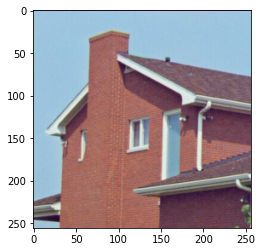

In [7]:
# seu código vem aqui
imagemT2 = imageio.imread('4.1.05.tiff')
plt.imshow(imagemT2)
plt.plot()
nx,ny,nc = imagemT2.shape
nx,ny,nc

## Identificação dos pixels indesejados

<a name="celula-pixels-indesejados"></a>
(d) Utilize uma ferramenta externa para marcar os pixels indesejados e exiba o resultado aqui.
Algumas sugestões são: (i) no Windows, utilize o velho e bom Paint; no Linux, o Gimp é mais do que suficiente;
(ii) marque os pixels com uma cor simples (por exemplo, vermelho, azul, verde ou amarelo) com nenhum ou pouca frequência na imagem; (iii) não salve por cima da imagem original!

(256, 256, 3)

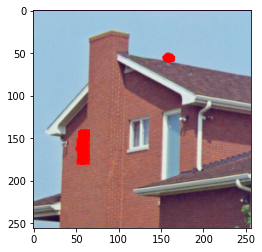

In [8]:
# seu código vem aqui
ImagemTeste = imageio.imread('003.jpg')
plt.imshow(ImagemTeste)
plt.plot()
nx,ny,nc = ImagemTeste.shape
nx,ny,nc

In [12]:
# Matriz auxiliar I
I = np.zeros((ny,nx), dtype=int)
Eq = 0
for i in range(ny):
  for j in range(nx):
    if(ImagemTeste[i,j,0]>=100 and ImagemTeste[i,j,1]<=50 and ImagemTeste[i,j,2]<=50):
      I[i,j] = Eq
      Eq+=1
    else:
      I[i,j] = -1

print("Pixels indesejados: ", Eq+1)
print("Número de equações: ", Eq+1)

Pixels indesejados:  785
Número de equações:  785


## Montagem do sistema de equações

<a name="celula-montagem"></a>
(e) Nesta etapa, vocês devem construir os sistemas de equações correspondentes a cada canal. Aqui, são criados tanto a matriz `A` quanto os vetores independentes `br`, `bg` e `bb`.

In [13]:
# seu código vem aqui
A = np.zeros((Eq, Eq))
br = np.zeros(Eq)
bg = np.zeros(Eq)
bb = np.zeros(Eq)

for i in range(ny):
  for j in range(nx):
    if(I[i,j]!=-1):
      eq = I[i,j]
      A[eq,eq] = 4.0
      if(I[i-1,j]!=-1):
        A[eq,I[i-1,j]] = -1; 
      else:
        br[eq] += ImagemTeste[i-1, j, 0]
        bg[eq] += ImagemTeste[i-1, j, 1]
        bb[eq] += ImagemTeste[i-1, j, 2]

      if(I[i,j+1]!=-1):
        A[eq,I[i,j+1]] =-1;
      else:
        br[eq] += ImagemTeste[i, j+1, 0]
        bg[eq] += ImagemTeste[i, j+1, 1]
        bb[eq] += ImagemTeste[i, j+1, 2]

      if(I[i+1,j]!=-1):
        A[eq,I[i+1,j]] = -1; 
      else:
        br[eq] += ImagemTeste[i+1, j, 0]
        bg[eq] += ImagemTeste[i+1, j, 1]
        bb[eq] += ImagemTeste[i+1, j, 2]

      if(I[i,j-1]!=-1):
        A[eq,I[i,j-1]] =-1;
      else:
        br[eq] += ImagemTeste[i, j-1, 0]
        bg[eq] += ImagemTeste[i, j-1, 1]
        bb[eq] += ImagemTeste[i, j-1, 2]

In [14]:
A

array([[ 4., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  4., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  4., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  4., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  4.]])

## Solução dos sistemas lineares

<a name="celula-resolve"></a>
(f) Como a matriz $\mathbf{A}$ não possui diagonal estritamente dominante, nem é simétrica, uma alternativa para melhorar as propriedades numéricas da matriz é conhecida como *precondicionamento*.
Ao invés de resolver o sistema original, vocês devem considerar o sistema ${\displaystyle \mathbf{A}\mathbf{D}^{-1}(\mathbf{D}\mathbf{x})=\mathbf{b}}$, onde $\mathbf{D}$ é uma matriz diagonal formada pelos coeficientes da diagonal de $\mathbf{A}$, para então, resolver:

1. ${\displaystyle \mathbf{A}\mathbf{D}^{-1}\mathbf{y}=\mathbf{b}}$
2. ${\displaystyle \mathbf{D}\mathbf{x}=\mathbf{y}}$

utilizando um método numérico de sua escolha.

In [15]:
def resolve(A,b):
  n = A.shape[0]
  y = b.copy()
  U = A.copy()
  for k in range(0,n-1):
      for i in range(k+1,n):
          l = U[i,k]/U[k,k]
          for j in range(k+1,n):
              U[i,j] = U[i,j] - l*U[k,j]
          U[i,k] = 0.0
          y[i] = y[i] - l*y[k]

  x = np.zeros(y.shape)
  x[n-1] = y[n-1]/U[n-1,n-1]
  for i in range(n-2,-1,-1):
      s = y[i]
      for j in range(i+1,n):
          s = s - U[i,j]*x[j]
      x[i] = s/U[i,i]
      
  return x

*Verifique sua implementação aplicando-a no exemplo abaixo.*

In [ ]:
# Sistema de teste
B = np.array([[4.0, 3, 2], [-2, 2, 3], [3, -5, 2]])
c = np.array([[25.0], [-10], [-4]])

# Cálculo da solução
y = resolve(B, c)

# Verifica, elemento a elemento, se By vale c, com tolerância de 1e-08 (por padrão)
np.allclose(np.dot(B, c), y)

False

## Cálculo das novas cores

Agora, você já pode calcular as novas cores dos pixels indesejados. Basta executar a célula abaixo:

In [16]:
print('calculando R')
xr = resolve(A,br)

print('calculando G')
xg = resolve(A,bg)

print('calculando B')
xb = resolve(A,bb)

calculando R
calculando G
calculando B


## Exibição da imagem retocada

<a name="celula-imagem-retocada"></a>
(g) Por fim, atualize sua imagem e exiba o resultado do retoque.

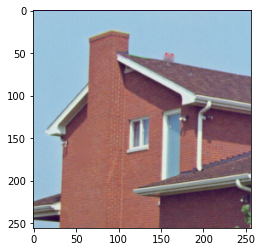

In [17]:
# seu código vem aquifor a in range(contadorEq):
for i in range(ny):
    for j in range(nx):
      if I[i,j] != -1:
        k = I[i,j]
        ImagemTeste[i,j,0] = xr[k]
        ImagemTeste[i,j,1] = xg[k]
        ImagemTeste[i,j,2] = xb[k]
plt.imshow(ImagemTeste)
plt.show()

## Saiba mais

* Esta atividade foi baseada no artigo "Image inpainting", de Marcelo Bertalmio, Guillermo Sapiro, Vincent Caselles e Coloma Ballester, disponível em https://doi.org/10.1145/344779.344972.

2022 Vicente Helano  
UFCA | Centro de Ciências e Tecnologia